# Diffuse 511 Spectral Fit in Galactic Coordinates

This notebook fits the spectrum for the 511 keV emission in the Galaxy. It can be used as a general template for fitting diffuse/extended sources in Galactic coordinates. For a general introduction into spectral fitting with cosipy, see the continuum_fit and line_fit tutorials. The main difference here is that we calculate the point source response for a diffuse source (in Galactic coordinates). <br>

The input model is available here: <br>
https://github.com/cositools/cosi-data-challenges/tree/main/cosi_dc/Source_Library/DC2/sources/511/511_Testing <br>
It is a toy 511 model, consisting of two components: an extended Gaussian source (5 degree extension) and a point source. In the first part of this tutorial, we fit the data with just the single extended Gaussian component, i.e. we ignore the point source component. This is done as a simplification, and as will be seen, it already provides a good fit. In the second part of this tutorial we use a model consisting of both components (this part is not yet ready). 

For the background we use just the cosmic photons. 

This tutotrial also walks through all the steps needed when performing a spectral fit, starting with the unbinned data, i.e. creating the combined data set, and binning the data. 

You will need the following files (available on wasabi):<br>
**20280301_3_month.ori <br>
cosmic_photons_3months_unbinned_data.fits.gz <br>
511_Testing_3months.fits.gz <br>
SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5 <br>
psr_gal_511_DC2.h5** <br>

The binned data products are available on wasabi (directory below), so you can also start by loading the binned data directly: <br>
COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame/

**WARNING:** If you run into memory issues creating the combined dataset or binning the data on your own, start by just loading the binned data directly. We are still working on optimizing the code, so please let us know if you run into these memory issues. <br>

**Note:** <br>
One of the purposes of this notebook is to aid in development of the extended source spectral fit, and so it contains some extra information which may be useful.  

In [1]:
# imports:
from cosipy import COSILike, test_data, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from scoords import SpacecraftFrame
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astromodels import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from threeML import PointSource, Model, JointLikelihood, DataList
from astromodels import Parameter
from astromodels import *
from mhealpy import HealpixMap, HealpixBase
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path
import os
import time
import h5py as h5
from histpy import Axis, Axes
import sys
from cosipy.response import PointSourceResponse
from histpy import Histogram

07:20:38 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=218433;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=739366;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=331628;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=868123;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

07:20:39 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=429106;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=394106;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=587712;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=699113;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=20539;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=779838;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=416633;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=295857;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=305813;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=873914;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=377062;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=208930;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=87500;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=634598;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

07:20:39 INFO      Starting 3ML!                                                                     ]8;id=139861;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=51142;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=64948;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=424963;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=222072;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=612160;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=981388;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=771700;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   no display variable set. using backend for graphics without display (agg)         ]8;id=914674;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=100109;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#46\46]8;;\

/zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: dev is an invalid version and will not be supported in a future release
  warnings.warn(


07:20:40 WARNING   ROOT minimizer not available                                                ]8;id=260784;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=435128;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=440402;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=90177;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=146596;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=586559;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

07:20:40 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=91874;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=362203;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=575287;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=287242;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=578991;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=580552;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

07:20:41 WARNING   No fermitools installed                                              ]8;id=904781;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=799848;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

07:20:41 WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=259246;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=671568;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=479536;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=817865;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Get the data
The data can be downloaded directly from wasabi, or you can copy them by running the cells below. Each respective cell also gives the path to the file, in case you are looking for the location on wasabi. 

In [ ]:
# ori file:
# wasabi path: COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori --endpoint-url=https://s3.us-west-1.wasabisys.com 20280301_3_month.ori")

In [ ]:
# cosmic photons:
# wasabi path: COSI-SMEX/DC2/Data/Backgrounds/cosmic_photons_3months_unbinned_data.fits.gz
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Backgrounds/cosmic_photons_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com cosmic_photons_3months_unbinned_data.fits.gz")

In [ ]:
# 511:
# wasabi path: COSI-SMEX/DC2/Data/Sources/511_Testing_3months.fits.gz 
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Sources/511_Testing_3months.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com 511_Testing_3months.fits.gz")

In [ ]:
# detector response:
# wasabi path: COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5 --endpoint-url=https://s3.us-west-1.wasabisys.com SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5")

In [ ]:
# point source response:
# wasabi path: COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz
COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz --endpoint-url=https://s3.us-west-1.wasabisys.com psr_gal_511_DC2.h5.gz")

In [ ]:
# Binned data products:
# wasabi path: COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame 
file_list = ['cosmic_photons_binned_data.hdf5','gal_511_binned_data.hdf5','combined_binned_data.hdf5']

for each in file_list:
    os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame/%s --endpoint-url=https://s3.us-west-1.wasabisys.com %s" %(each,each))

## Create the combined data
We will combine the 511 source and the cosmic photon background, which will be used as our dataset. <br>
This only needs to be done once.<br>
You can skip this cell if you already have the combined data file.

In [2]:
# Define instance of binned data class:
instance = BinnedData("Gal_511.yaml") 

# Combine files:
input_files = ["cosmic_photons_3months_unbinned_data.fits.gz","511_Testing_3months.fits.gz"]
instance.combine_unbinned_data(input_files, output_name="combined_data")


adding cosmic_photons_3months_unbinned_data.fits.gz...


adding 511_Testing_3months.fits.gz...



## Bin the data 
You only have to do this once, and after you can start by loading the binned data directly. <br>
You can skip this cell if you already have the binned data files.

In [3]:
# Bin 511:
gal_511 = BinnedData("Gal_511.yaml")
gal_511.get_binned_data(unbinned_data="511_Testing_3months.fits.gz", output_name="gal_511_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [4]:
# Bin background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.get_binned_data(unbinned_data="cosmic_photons_3months_unbinned_data.fits.gz", output_name="cosmic_photons_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [5]:
# Bin combined data:
data_combined = BinnedData("Gal_511.yaml")
data_combined.get_binned_data(unbinned_data="combined_data.fits.gz", output_name="combined_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


## Read in the binned data
Once you have the binned data files, you can start by loading them directly (instead of binning them each time).

In [2]:
# Load 511:
gal_511 = BinnedData("Gal_511.yaml")
gal_511.load_binned_data_from_hdf5(binned_data="gal_511_binned_data.hdf5")

# Load background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.load_binned_data_from_hdf5(binned_data="cosmic_photons_binned_data.hdf5")

# Load combined data:
data_combined = BinnedData("Gal_511.yaml")
data_combined.load_binned_data_from_hdf5(binned_data="combined_binned_data.hdf5")

## Define Source
The injected source has both an extended componenent and a point source component, <br>
but to start with we will ignore the point source component, <br>
and see how well we can describe the data with just the extended component. <br>
Define the extended source:

In [3]:
# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 4e-2 / u.cm / u.cm / u.s  
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum = Gaussian()
spectrum.F.value = F.value
spectrum.F.unit = F.unit
spectrum.mu.value = mu.value
spectrum.mu.unit = mu.unit
spectrum.sigma.value = sigma.value
spectrum.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum.F.free = True
spectrum.mu.free = True
spectrum.sigma.free = False

# Define morphology:
morphology = Gaussian_on_sphere(lon0 = 359.75, lat0 = -1.25, sigma = 5)

# Set morphological parameters for fitting:
morphology.lon0.free = False
morphology.lat0.free = False
morphology.sigma.free = False

# Define source:
src1 = ExtendedSource('gaussian', spectral_shape=spectrum, spatial_shape=morphology)

# Print a summary of the source info:
src1.display()

# We can also print the source info as follows.
# This will also show you which parameters are free. 
#print(src1.spectrum.main.shape)
#print(src1.spatial_shape)

# Convert to healpix map and make it an object of the source:
# The healpix map needs to match the detector response.
# This still needs be moved to internal source code.
# Correspondingly, we still need a class to handle models in an efficient and convenient way.
src1.skymap = HealpixMap(nside = 16, scheme = "ring", dtype = float, coordsys='G')
coords1 = src1.skymap.pix2skycoord(range(src1.skymap.npix))

# Define skymap: 
src1.skymap[:] = src1.Gaussian_on_sphere(coords1.l.deg, coords1.b.deg)

# Add grid property to source. These are the pixles that will be summed over for the likelihood calculation.
# By default, the grid is the entire sky, but a few cells below shows an example of selecting pixels within a given radius from the source, 
# which makes things faster for testing. 
src1.grid = np.arange(0,src1.skymap.npix)

# Check normalization:
# Note: The skymap is normalized so that the sum over the entire sky,
# multiplied by the pixel area, equals 1.
print("summed map: " + str(np.sum(src1.skymap)*4*np.pi/src1.skymap.npix))

* gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.04
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma:
            * value: 0.85
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
        * polarization: {}

summed map: 0.9974653836229356


Let's make some plots to look at the extended source:

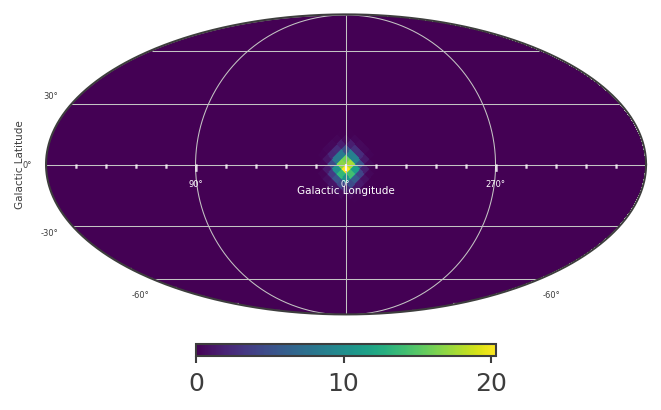

In [5]:
# Plot healpix map:
plot, ax = src1.skymap.plot(ax_kw = {'coord':'G'})
ax.grid()
lon = ax.coords['glon']
lat = ax.coords['glat']
lon.set_axislabel('Galactic Longitude',color='white',fontsize=5)
lat.set_axislabel('Galactic Latitude',fontsize=5)
lon.display_minor_ticks(True)
lat.display_minor_ticks(True)
lon.set_ticks_visible(True)
lon.set_ticklabel_visible(True)
lon.set_ticks(color='white',alpha=0.6)
lat.set_ticks(color='white',alpha=0.6)
lon.set_ticklabel(color='white',fontsize=4)
lat.set_ticklabel(fontsize=4)
lat.set_ticks_visible(True)
lat.set_ticklabel_visible(True)

Text(0.5, 0, 'Energy [keV]')

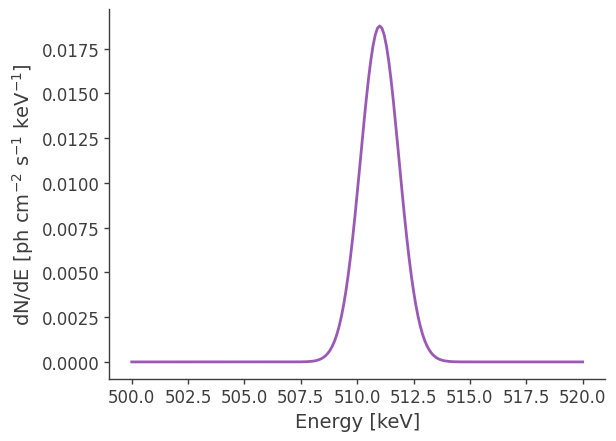

In [6]:
# Plot spectrum:
energy = np.linspace(500.,520.,201)*u.keV
dnde = src1.spectrum.main.Gaussian(energy)
plt.plot(energy, dnde)
plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14)

Below we plot the weights. Note that for extended sources the weights also need to include the pixel area.

(1e-50, 1)

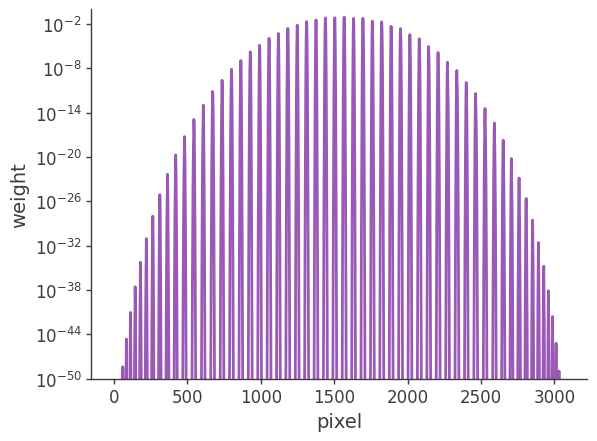

In [7]:
plt.semilogy(src1.skymap[:]*4*np.pi/src1.skymap.npix)
plt.ylabel("weight")
plt.xlabel("pixel")
plt.ylim(1e-50,1)

Many of the pixels are essentially zero; however, if you examine the actaul numerical value you'll see that the values are extremely small, but not exactly zero. The likelihood fit is currently setup to skip pixels with value of zero, and this significantly speeds up the calculation. So one option is to define a threshold, below which we set the pixels to zero, as done below. But skip this cell for now, and just keep it in mind for testing later on. 

(1e-50, 1)

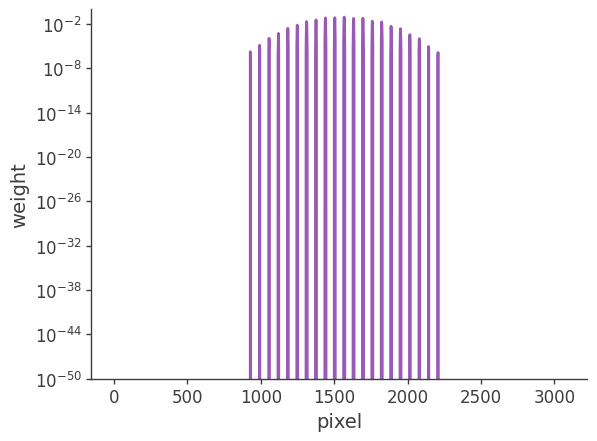

In [4]:
# Set low pixels to zero:
src1.skymap[src1.skymap[:] < 1e-4] = 0

# Plot:
plt.semilogy(src1.skymap[:]*4*np.pi/src1.skymap.npix)
plt.ylabel("weight")
plt.xlabel("pixel")
plt.ylim(1e-50,1)

Next we will define a sky grid by selecting pixels within a given radius of our source. This is a property that we gave to our source in the definition above. The likelihood fit will sum over pixels in the grid. In order to speed up the likelihood scan (for efficient testing), we will select a small number of pixels here. 

## Load Response

In [3]:
response_file = "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
response = FullDetectorResponse.open(response_file)

## Make Sky Grid
Grid the sky in Galactic coordinates, using the same nside as the response:

In [4]:
nside = response.nside # same as detector response
gal_grid = HealpixBase(nside = nside, coordsys = 'galactic')
gal_coords = gal_grid.pix2skycoord(range(gal_grid.npix))
print("Approximate resolution at NSIDE {} is {:.2} deg".format(nside, hp.nside2resol(nside, arcmin=True) / 60))
print("Number of bins: " + str(len(gal_coords)))
print(gal_coords)

Approximate resolution at NSIDE 16 is 3.7 deg
Number of bins: 3072
<SkyCoord (Galactic): (l, b) in deg
    [( 45.,  87.07581964), (135.,  87.07581964), (225.,  87.07581964), ...,
     (135., -87.07581964), (225., -87.07581964), (315., -87.07581964)]>


Select which pixels to sum in the response calculation. <br>
Note: This step is not needed if you want to use the entire sky.

In [5]:
# Query disk around Galactic center:
l = np.deg2rad(0)
b = np.deg2rad(0)
radius = np.deg2rad(7)
this_pix = gal_grid.ang2pix(l,b,lonlat=True)
vec = gal_grid.pix2vec(this_pix)
grid = gal_grid.query_disc(vec, radius)
print("pixel grid: " + str(grid))
print(gal_coords[grid])

pixel grid: [1312 1376 1439 1440 1441 1503 1504 1567 1568]
<SkyCoord (Galactic): (l, b) in deg
    [(  0.    ,  7.18075578), (  2.8125,  4.78019185),
     (357.1875,  4.78019185), (  0.    ,  2.38801546),
     (  5.625 ,  2.38801546), (354.375 ,  2.38801546),
     (  2.8125,  0.        ), (357.1875,  0.        ),
     (  0.    , -2.38801546)]>


Now updte the grid property of the source:

In [7]:
src1.grid = grid

## Rotating Detector Response (optional section)
Here we calcuate the point source response by rotating the detector response to the Galactic frame. The rotation is time-consuming, and so in general,
this can be slow, especially if you're summing pixels from the entire sky. The default method uses a precomputed point source response file, which is obtained by the general procedure described in this section. It is ran on a high perfomance computer cluster, using 1000 CPUs, which makes things fast. In this section we also walk through some good sanity checks. You can skip to the "Main Method" section if you want. 

## Get point source response in Galactic coordinates
We will get the point source response in Galactic coordinates.<br>
See detector response tutorial for more details.<br>
Warning: This can take a while, depending on how many points you use. In this example, we'll use the grid that we defined above.

In [12]:
# Get pointing information:
ori = SpacecraftFile.parse_from_file("20280301_3_month.ori")

# calculate scatt map:
scatt_map = ori.get_scatt_map(nside = response.nside * 2, coordsys = 'galactic')


WARNING ErfaWarning: ERFA function "utctai" yielded 7979956 of "dubious year (Note 3)"



In [13]:
# Calculate the point source response for all passed coordinates
# Note: If using the entire sky, then remove the grid indices in gal_coords. 
start = time.time()
grid_response = response.get_point_source_response(coord = gal_coords[grid], scatt_map = scatt_map)
stop = time.time()
total_time = stop - start
print("processing time [min]: " + str(total_time/60.0))
print(grid_response)

processing time [min]: 27.944880882898968
(<cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1501e5666970>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1501e5666280>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1501e5666df0>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1501e5666520>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1501e56b39d0>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1501e56b3100>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1501e56b3310>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1501e56b38b0>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1501e56b3a00>)


## Get Expectation for Extended Source
We will get the expectation for each point in our sky grid, and add them together to get the expectation for an extended source. <br>
Note: The expectation for a given pixel is based on the same spectrum, but then weighted using the weights from the skymap that we made above. <br>

In [ ]:
# Testing only:
# Use this cell if you are just using 1 pixel. 
# Otherwise, use the cell below. 
this_pix = grid[0]
weight = skymap1[this_pix]*4*np.pi/skymap1.npix 
total_expectation = grid_response.get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi']) * weight
print(total_expectation)

In [14]:
# Sum expected counts:
for i in range(0,len(grid_response)):
    
    # Get weight
    this_pix = grid[i]
    weight = src1.skymap[this_pix]*4*np.pi/src1.skymap.npix
    
    if i == 0:
        total_expectation = grid_response[i].get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi']) * weight
    if i > 0:
        this_expectation = grid_response[i].get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi']) * weight
        total_expectation += this_expectation

## Make Some Sanity Checks: 
Below you will notice that the expected counts is smaller than the injected counts.<br>
This is because we have only used the extended component. <br>
Later we will see that the model gets scaled up in the likelihood fit. 

In [15]:
# First print a summary of the components:
print("Bin edges: " + str(data_combined.binned_data.axes['Em'].edges))
print("Data counts: " + str(data_combined.binned_data.project('Em').contents.todense()))
print("BG counts: " + str(bg_tot.binned_data.project('Em').contents.todense()))
print("Expected src counts: " + str(total_expectation.project('Em').contents))
print("Injected src counts: " + str(gal_511.binned_data.project('Em').contents.todense()))

Bin edges: [509. 513.] keV
Data counts: [4759387.]
BG counts: [242973.]
Expected src counts: [1784132.22687289] cm2 / cm2
Injected src counts: [4516414.]


Text(0.5, 1.0, 'injected counts')

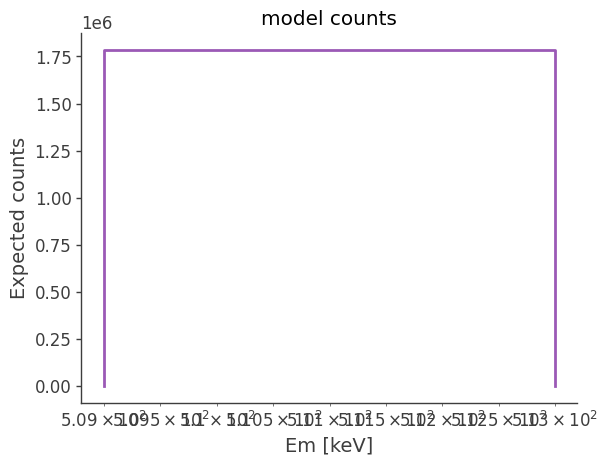

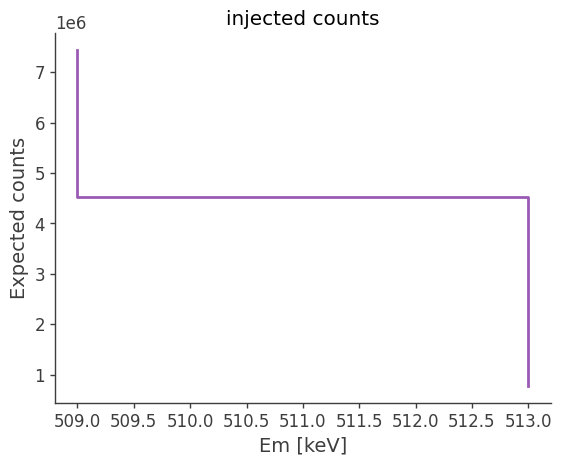

In [16]:
# expected src counts:
ax, plot = total_expectation.project('Em').plot()
ax.set_ylabel('Expected counts')
plt.title("model counts")

# injected src counts:
ax, plot = gal_511.binned_data.project('Em').plot()
ax.set_ylabel('Expected counts')
plt.title("injected counts")

Now let's look at a slice in the CDS projected onto the PsiChi dimension. <br>
You'll notice that compared to the Compton ring of a point source,<br>
the ring of the extended source is wider and more blurred out.

Text(0.5, 1.0, 'injected counts')

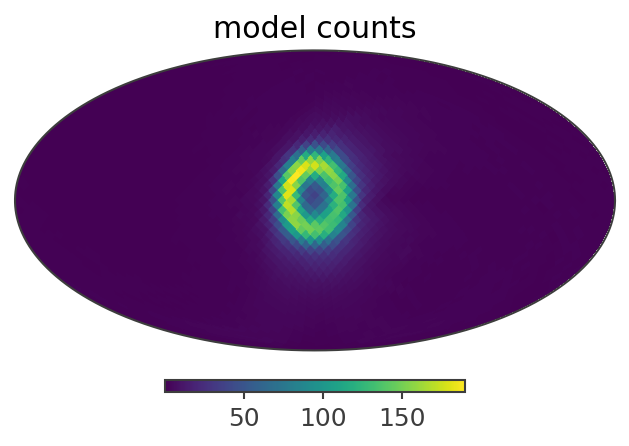

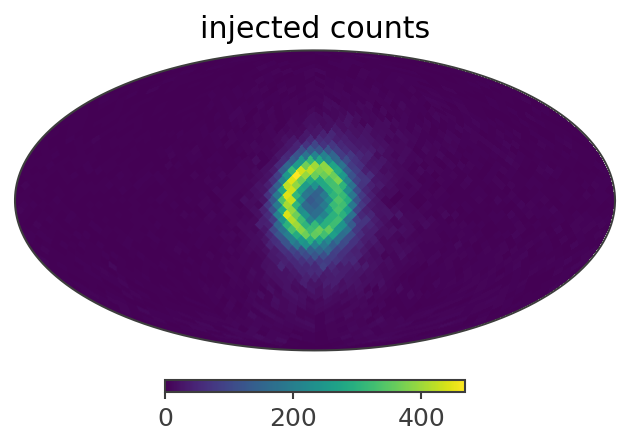

In [17]:
# expected src counts:
ax,plot = total_expectation.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("model counts")

# injected src counts:
ax,plot = gal_511.binned_data.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("injected counts")

# uncomment below if you want to make some overlays:
#coord = SkyCoord(0*u.deg,0*u.deg,frame="galactic")
#ax.scatter([coord.l.deg], [coord.b.deg], transform = ax.get_transform('world'), marker = 'o', color = 'red')

## Main Method: Use Precomputed Point Source Response in Galactic Coordinates
Load the detector response, ori file, and psr file. 

In [9]:
response_file = "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
response = FullDetectorResponse.open(response_file)
ori = SpacecraftFile.parse_from_file("20280301_3_month.ori")
psr_file = "psr_gal_511_DC2.h5"

The next few cells below are already implemented within cosipy. There are included here to demonstrate how the code works. You can skip to the 3ML cell if you want. <br><br>
Load the precomputed point source response, and get the information for the axes:

In [19]:
with h5.File(psr_file) as f:

    axes_group = f['hist/axes']
    
    axes = []
    
    for axis in axes_group.values():

        # Get class. Backwards compatible with version
        # with only Axis
        axis_cls = Axis
    
        if '__class__' in axis.attrs:
            class_module, class_name = axis.attrs['__class__']
            axis_cls = getattr(sys.modules[class_module], class_name)
    
        axes += [axis_cls._open(axis)]

axes = Axes(axes)
axes.labels

array(['NuLambda', 'Ei', 'Em', 'Phi', 'PsiChi'], dtype='<U8')

Calculate the expectation, using the full sky:

In [23]:
start = time.time()
expectation = Histogram(edges = axes[2:])
full_grid = np.arange(0,src1.skymap.npix) # full sky

with h5.File(psr_file) as f:

     for i in range(len(full_grid)):
        
        pix = full_grid[i]
        weight = src1.skymap[pix]
        
        if weight == 0:
            continue
        
        psr = PointSourceResponse(axes[1:], f['hist/contents'][pix+1], unit = f['hist'].attrs['unit'])
        pix_expectation = psr.get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi'])
        
        expectation += pix_expectation*(weight*4*np.pi/src1.skymap.npix)

total_time = time.time() - start
print("calculation time: " + str(total_time))

calculation time: 109.95973920822144


Let's plot a slice in the CDS projected onto the PsiChi dimension. Note that compared to the approach we used above, the model counts here are closer to the actual injected signal, becuase we have summed over the entire sky.  

(<Mollview: >, <matplotlib.image.AxesImage at 0x1501e9d2fa00>)

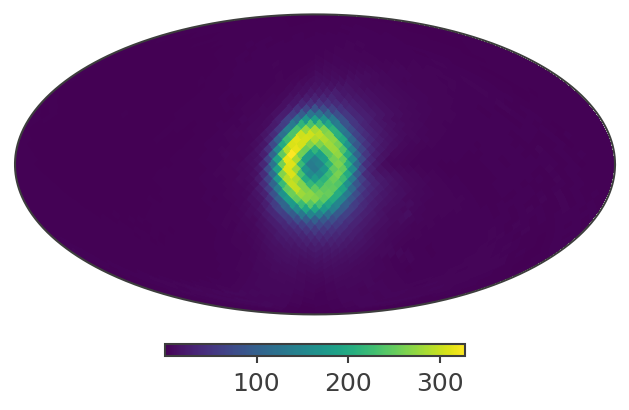

In [24]:
expectation.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})

In calculating the expectation above, we are looping through all pixels. This takes almost 2 minutes. When the likelihood fit is performed, this gets called many times, and therefore the likehood may take a long time to finish. Another approach would be to calculate the point source response for all pixels at once, as done in the cell below. However, this is actually slower! Another alternative would be to set a flux threshold, below which pixels are ignored in the sum, as done earlier in the notebook. In the end, it may just take longer to fit diffuse sources, which isn't suprising because we are doing an all-sky fit. 

In [25]:
start = time.time()
with h5.File(psr_file) as f:
    psr = PointSourceResponse(axes, f['hist/contents'], unit = f['hist'].attrs['unit'])
    pix_expectation = psr.get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi'])
total_time = time.time() - start
print("calculation time: " + str(total_time))

calculation time: 139.86668848991394


(<Mollview: >, <matplotlib.image.AxesImage at 0x1501e5f32100>)

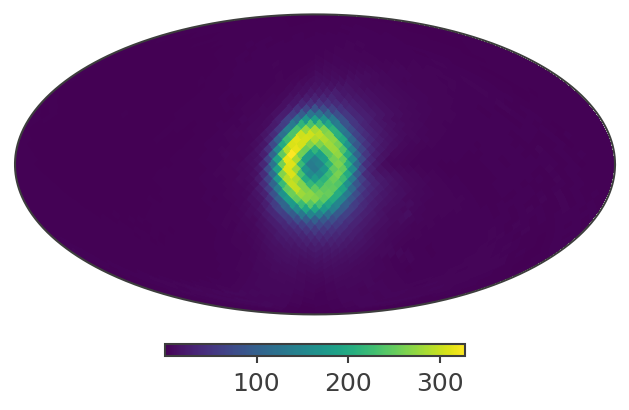

In [26]:
expectation.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})

## Setup the COSI 3ML plugin and Perform the Likelihood Fit

In [9]:
# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

# Instantiate the COSI 3ML plugin
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined.binned_data.project('Em', 'Phi', 'PsiChi'),       # data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),          # background model 
                sc_orientation = ori,                                          # spacecraft orientation
                nuisance_param = bkg_par,                                      # background parameter
                precomputed_psr_file = psr_file)                               # full path to precomputed psr file in galactic coordinates (optional)
                 
# Add sources to model:
model = Model(src1)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

Perform likelihood fit: 

In [10]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = False)

like.fit()

14:37:32 INFO      set the minimizer to minuit                                             ]8;id=87503;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=83793;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply




14:38:09 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=245663;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=57843;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(1.003 +/- 0.004) x 10^-1,1 / (cm2 s)
gaussian.spectrum.main.Gaussian.mu,(5.110 +/- 0.010) x 10^2,keV
background_cosi,1.168 +/- 0.005,


Correlation matrix:

1.00,0.99,-0.05
0.99,1.00,0.00
-0.05,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.521754e+07
total,-1.521754e+07


Values of statistical measures:

,statistical measures
AIC,-3.043509e+07
BIC,-3.043508e+07


(                                         value  negative_error  \
 gaussian.spectrum.main.Gaussian.F     0.100342       -0.000414   
 gaussian.spectrum.main.Gaussian.mu  511.000000       -0.978909   
 background_cosi                       1.167921       -0.004850   
 
                                     positive_error     error         unit  
 gaussian.spectrum.main.Gaussian.F         0.000394  0.000404  1 / (cm2 s)  
 gaussian.spectrum.main.Gaussian.mu        0.927930  0.953419          keV  
 background_cosi                           0.005046  0.004948               ,
        -log(likelihood)
 cosi      -1.521754e+07
 total     -1.521754e+07)

## Results
First, let's just print the results. <br>
Notice that the normalization is 2.5X higher than the injected spectrum. <br>
This is because we fit the data with only a single component. 

In [11]:
results = like.results
results.display()

# Print a summary of the optimized model:
print(results.optimized_model["gaussian"])

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(1.003 +/- 0.004) x 10^-1,1 / (cm2 s)
gaussian.spectrum.main.Gaussian.mu,(5.110 +/- 0.010) x 10^2,keV
background_cosi,1.168 +/- 0.005,


Correlation matrix:

1.00,0.99,-0.05
0.99,1.00,0.00
-0.05,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.521754e+07
total,-1.521754e+07


Values of statistical measures:

,statistical measures
AIC,-3.043509e+07
BIC,-3.043508e+07


  * gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.10034249147452041
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
        

Now let's make some plots. <br>
Let's first look at the best-fit spectrum:

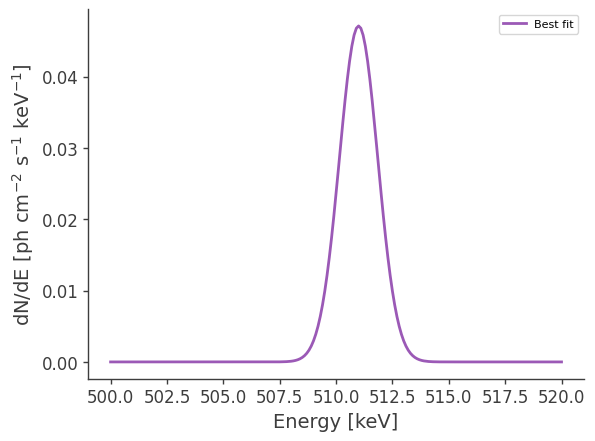

In [12]:
# Best-fit model:
energy = np.linspace(500.,520.,201)*u.keV
flux = results.optimized_model["gaussian"].spectrum.main.shape(energy)

fig,ax = plt.subplots()

ax.plot(energy, flux, label = "Best fit")


plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14)
ax.legend()

Now let's convolve the best-fit spectrum with the response, and compare the predicted counts to the injected counts. 

In [13]:
# First get axes information, in case you didn't run this cell above:
with h5.File(psr_file) as f:

    axes_group = f['hist/axes']
    
    axes = []
    
    for axis in axes_group.values():

        # Get class. Backwards compatible with version
        # with only Axis
        axis_cls = Axis
    
        if '__class__' in axis.attrs:
            class_module, class_name = axis.attrs['__class__']
            axis_cls = getattr(sys.modules[class_module], class_name)
    
        axes += [axis_cls._open(axis)]

axes = Axes(axes)
axes.labels

# Now convolve best-fit spectrum:
spectrum = results.optimized_model["gaussian"].spectrum.main.shape
total_expectation = Histogram(edges = axes[2:])
with h5.File(psr_file) as f:
  
    for i in range(len(src1.grid)): # subset of pixels
        
        pix = src1.grid[i]
        weight = src1.skymap[pix]
            
        if weight == 0:
            continue
        
        psr = PointSourceResponse(axes[1:], f['hist/contents'][pix+1], unit = f['hist'].attrs['unit'])
        pix_expectation = psr.get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi'])
        
        total_expectation += pix_expectation*(weight*4*np.pi/src1.skymap.npix)

Error: [2115.56300287]


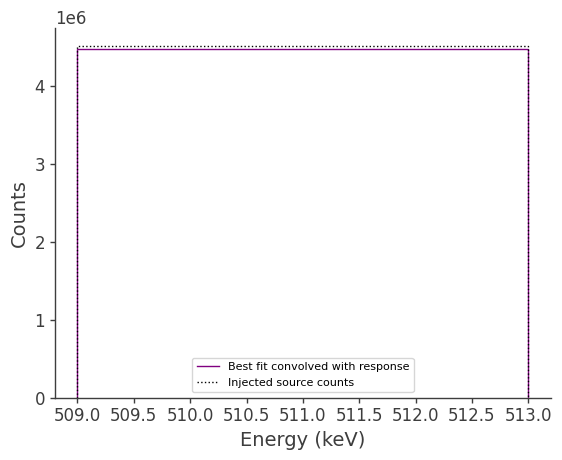

In [14]:
# Plot:       
fig,ax = plt.subplots()

binned_energy_edges = gal_511.binned_data.axes['Em'].edges.value
binned_energy = gal_511.binned_data.axes['Em'].centers.value

ax.stairs(total_expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, total_expectation.project('Em').todense().contents, yerr=np.sqrt(total_expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(gal_511.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Injected source counts")
ax.errorbar(binned_energy, gal_511.binned_data.project('Em').todense().contents, yerr=np.sqrt(gal_511.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

# Note: We are plotting the error, but it's very small:
print("Error: " +str(np.sqrt(total_expectation.project('Em').todense().contents)))

Let's also compare the projection onto Psichi:

Text(0.5, 1.0, 'injected counts')

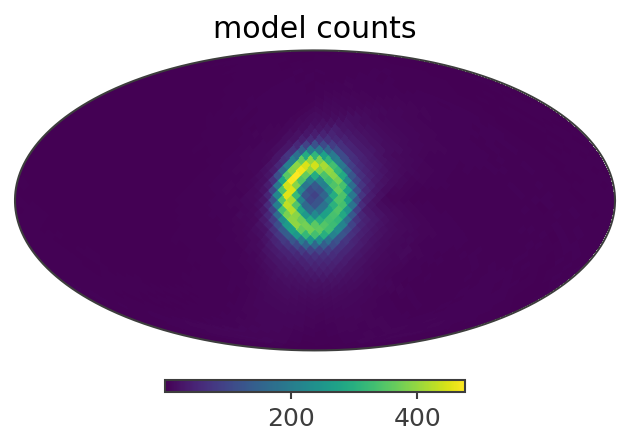

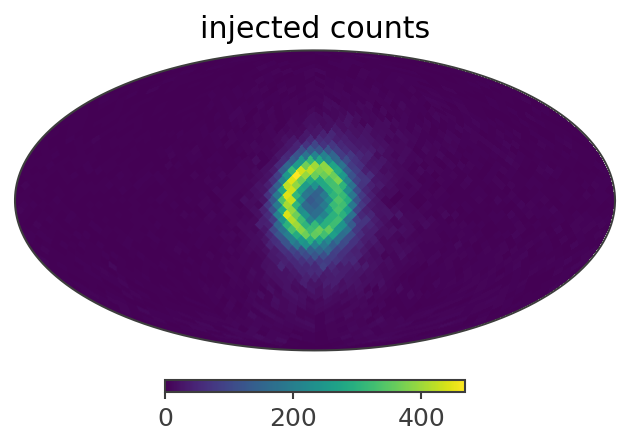

In [15]:
# expected src counts:
ax,plot = total_expectation.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("model counts")

# injected src counts:
ax,plot = gal_511.binned_data.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("injected counts")

# **********************************************************
## Perform Analysis with Two Comptonents

Redefine the response and ori files here, just in case you skipped the first part of the tutorial:

In [ ]:
response_file = "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
response = FullDetectorResponse.open(response_file)
ori = SpacecraftFile.parse_from_file("20280301_3_month.ori")
psr_file = "psr_gal_511_DC2.h5"

Define the point source. <br>
We'll add this to the model, and keep just the normalization free.

In [14]:
# Note: Astromodels only takes ra,dec for point source input:
c = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
c_icrs = c.transform_to('icrs')

# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 4e-2 / u.cm / u.cm / u.s  
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum2 = Gaussian()
spectrum2.F.value = F.value
spectrum2.F.unit = F.unit
spectrum2.mu.value = mu.value
spectrum2.mu.unit = mu.unit
spectrum2.sigma.value = sigma.value
spectrum2.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum2.F.free = True
spectrum2.mu.free = False
spectrum2.sigma.free = False

# Define source:
src2 = PointSource('point_source', ra = c_icrs.ra.deg, dec = c_icrs.dec.deg, spectral_shape=spectrum2)

# Print some info about the source just as a sanity check.
# This will also show you which parameters are free. 
print(src2.spectrum.main.shape)

# We can also get a summary of the source info as follows:
#src2.display()

  * description: A Gaussian function
  * formula: $ K \frac{1}{\sigma \sqrt{2 \pi}}\exp{\frac{(x-\mu)^2}{2~(\sigma)^2}} $
  * parameters:
    * F:
      * value: 0.04
      * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
      * min_value: null
      * max_value: null
      * unit: s-1 cm-2
      * is_normalization: false
      * delta: 0.1
      * free: true
    * mu:
      * value: 511.0
      * desc: Central value
      * min_value: null
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 0.1
      * free: false
    * sigma:
      * value: 0.85
      * desc: standard deviation
      * min_value: 1.0e-12
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 0.1
      * free: false



Redefine the first source.<br> 
We'll keep just the normalization free. 

In [15]:
# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 4e-2 / u.cm / u.cm / u.s  
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum = Gaussian()
spectrum.F.value = F.value
spectrum.F.unit = F.unit
spectrum.mu.value = mu.value
spectrum.mu.unit = mu.unit
spectrum.sigma.value = sigma.value
spectrum.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum.F.free = True
spectrum.mu.free = False
spectrum.sigma.free = False

# Define morphology:
morphology = Gaussian_on_sphere(lon0 = 359.75, lat0 = -1.25, sigma = 5)

# Set morphological parameters for fitting:
morphology.lon0.free = False
morphology.lat0.free = False
morphology.sigma.free = False

# Define source:
src1 = ExtendedSource('gaussian', spectral_shape=spectrum, spatial_shape=morphology)

# Print a summary of the source info:
src1.display()

# We can also print the source info as follows.
# This will also show you which parameters are free. 
#print(src1.spectrum.main.shape)
#print(src1.spatial_shape)

# Convert to healpix map and make it an object of the source:
# The healpix map needs to match the detector response.
# This still needs be moved to internal source code.
# Correspondingly, we still need a class to handle models in an efficient and convenient way.
src1.skymap = HealpixMap(nside = 16, scheme = "ring", dtype = float, coordsys='G')
coords1 = src1.skymap.pix2skycoord(range(src1.skymap.npix))

# Define skymap: 
src1.skymap[:] = src1.Gaussian_on_sphere(coords1.l.deg, coords1.b.deg)

# Add grid property to source. These are the pixles that will be summed over for the likelihood calculation.
# By default, the grid is the entire sky, but a few cells below shows an example of selecting pixels within a given radius from the source, 
# which makes things faster for testing. 
src1.grid = grid

# Check normalization:
# Note: The skymap is normalized so that the sum over the entire sky,
# multiplied by the pixel area, equals 1.
print("summed map: " + str(np.sum(src1.skymap)*4*np.pi/src1.skymap.npix))

* gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.04
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma:
            * value: 0.85
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
        * polarization: {}

summed map: 0.9974653836229356


Setup the COSI 3ML plugin using two sources in the model:

In [16]:
# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

# Instantiate the COSI 3ML plugin
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined.binned_data.project('Em', 'Phi', 'PsiChi'),       # data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),          # background model 
                sc_orientation = ori,                                          # spacecraft orientation
                nuisance_param = bkg_par,                                      # background parameter
                precomputed_psr_file = psr_file)                               # full path to precomputed psr file in galactic coordinates (optional)
                 
# Add sources to model:
model = Model(src1, src2)  # Model with two sources.

Display the model:

In [17]:
model.display()

Model summary:
==============

                  N
Point sources     1
Extended sources  1
Particle sources  0

Free parameters (2):
--------------------

                                      value min_value max_value      unit
gaussian.spectrum.main.Gaussian.F      0.04      None      None  s-1 cm-2
point_source.spectrum.main.Gaussian.F  0.04      None      None  s-1 cm-2

Fixed parameters (9):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

Let's first set the model, to make sure everything is working ok. You can skip this step if you want, because it's done automatically with the likelihood call. 

In [18]:
cosi.set_model(model)


WARNING ErfaWarning: ERFA function "utctai" yielded 7979956 of "dubious year (Note 3)"



Perform the likelihood fit:

In [19]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = True)

like.fit()

17:58:41 INFO      set the minimizer to minuit                                             ]8;id=754948;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=47863;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.04,0.04,1 -> logL = 12689924.874                        ]8;id=208738;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=273290;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.14,0.04,1 -> logL = 12403790.928                        ]8;id=697412;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=593518;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:42 INFO      trial values: -0.06,0.04,1 -> logL = 517463.487                         ]8;id=228508;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=169432;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.05,0.04,1 -> logL = 12910851.080                        ]8;id=447309;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=662144;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.03,0.04,1 -> logL = 12329289.112                        ]8;id=908669;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=328525;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:43 INFO      trial values: 0.041,0.04,1 -> logL = 12717374.539                       ]8;id=68313;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=150421;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.039,0.04,1 -> logL = 12661108.294                       ]8;id=241601;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=45105;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:44 INFO      trial values: 0.04,0.14,1 -> logL = 5504690.655                         ]8;id=531535;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=67358;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.04,-0.06,1 -> logL = 9237190.087                        ]8;id=275753;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=609297;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.04,0.05,1 -> logL = 12088688.800                        ]8;id=150735;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=622236;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:45 INFO      trial values: 0.04,0.03,1 -> logL = 13233474.023                        ]8;id=425286;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=110923;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.04,0.041,1 -> logL = 12632075.743                       ]8;id=222346;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=141147;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.04,0.039,1 -> logL = 12747206.300                       ]8;id=538604;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=482029;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:46 INFO      trial values: 0.04,0.04,1.0201 -> logL = 12689811.467                   ]8;id=568361;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=270393;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.04,0.04,0.98007 -> logL = 12690022.725                  ]8;id=221933;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=461545;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:47 INFO      trial values: 0.04,0.04,1.0125 -> logL = 12689855.977                   ]8;id=625279;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=337694;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.04,0.04,0.98755 -> logL = 12689987.719                  ]8;id=37035;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=194642;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.060581,-0.0614,0.86777 -> logL = 10746160.345           ]8;id=999807;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=988977;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:48 INFO      trial values: 0.047898,0.0010871,0.9484 -> logL = 14340323.164          ]8;id=635246;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=344388;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.047998,0.0010871,0.9484 -> logL = 14344656.046          ]8;id=426650;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=609770;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.047798,0.0010871,0.9484 -> logL = 14335973.508          ]8;id=386206;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=372270;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:49 INFO      trial values: 0.047962,0.0010871,0.9484 -> logL = 14343091.565          ]8;id=445941;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=542321;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.047834,0.0010871,0.9484 -> logL = 14337547.925          ]8;id=710714;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=806357;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:50 INFO      trial values: 0.047898,0.0011969,0.9484 -> logL = 14344552.770          ]8;id=985375;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=840130;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.047898,0.00097739,0.9484 -> logL = 14335796.237         ]8;id=478224;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=373427;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.047898,0.0011038,0.9484 -> logL = 14340983.151          ]8;id=61484;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=501949;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:51 INFO      trial values: 0.047898,0.0010705,0.9484 -> logL = 14339656.345          ]8;id=813858;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=778296;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.047898,0.0010871,0.96143 -> logL = 14342558.271         ]8;id=866474;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=108128;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.047898,0.0010871,0.93544 -> logL = 14338079.757         ]8;id=274302;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=941719;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:52 INFO      trial values: 0.071933,0.0056769,3.6682 -> logL = 14888725.969          ]8;id=63353;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=758869;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.066085,0.0045601,3.0089 -> logL = 14896423.303          ]8;id=682068;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=364076;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:53 INFO      trial values: 0.068513,0.0050238,3.2905 -> logL = 14900338.328          ]8;id=466869;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=64798;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.068578,0.0050238,3.2905 -> logL = 14901015.862          ]8;id=301124;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=583272;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.068448,0.0050238,3.2905 -> logL = 14899657.887          ]8;id=107751;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=513341;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:54 INFO      trial values: 0.068615,0.0050238,3.2905 -> logL = 14901396.329          ]8;id=814695;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=276312;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.068411,0.0050238,3.2905 -> logL = 14899273.222          ]8;id=886106;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=256147;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.068513,0.0050408,3.2905 -> logL = 14899761.387          ]8;id=337269;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=479159;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:55 INFO      trial values: 0.068513,0.0050069,3.2905 -> logL = 14900914.276          ]8;id=714408;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=695847;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.068513,0.0050692,3.2905 -> logL = 14898792.939          ]8;id=714485;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=568593;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:56 INFO      trial values: 0.068513,0.0049784,3.2905 -> logL = 14901876.612          ]8;id=77102;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=695298;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.068513,0.0050238,3.3051 -> logL = 14899753.188          ]8;id=604019;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=912126;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.068513,0.0050238,3.276 -> logL = 14900919.961           ]8;id=746984;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=779528;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:57 INFO      trial values: 0.085716,-0.0054117,4.224 -> logL = 14926670.905          ]8;id=95308;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=396139;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.077601,-0.00048893,3.8147 -> logL = 15072576.816        ]8;id=310466;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=208050;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:58 INFO      trial values: 0.077703,-0.00048893,3.8147 -> logL = 15073307.711        ]8;id=161240;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=134265;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.077498,-0.00048893,3.8147 -> logL = 15071825.248        ]8;id=231379;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=825522;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.077661,-0.00048893,3.8147 -> logL = 15072983.046        ]8;id=47058;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=134950;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:58:59 INFO      trial values: 0.07754,-0.00048893,3.8147 -> logL = 15072140.656         ]8;id=335441;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=927711;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.077601,-0.00044326,3.8147 -> logL = 15073314.051        ]8;id=49414;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=487247;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:00 INFO      trial values: 0.077601,-0.00053459,3.8147 -> logL = 15071899.612        ]8;id=539503;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=598809;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.077601,-0.00047313,3.8147 -> logL = 15072831.645        ]8;id=444610;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=671321;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.077601,-0.00050473,3.8147 -> logL = 15072352.579        ]8;id=43044;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=506372;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:01 INFO      trial values: 0.077601,-0.00048893,3.8333 -> logL = 15071775.317        ]8;id=76734;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=182254;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.077601,-0.00048893,3.796 -> logL = 15073319.374         ]8;id=402712;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=761805;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.077601,-0.00048893,3.8212 -> logL = 15072280.363        ]8;id=810287;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=434633;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:02 INFO      trial values: 0.077601,-0.00048893,3.8082 -> logL = 15072836.959        ]8;id=650997;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=45045;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.083828,0.00083441,2.5597 -> logL = 15150989.525         ]8;id=889542;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=624186;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:03 INFO      trial values: 0.088069,0.0017355,1.6735 -> logL = 15171527.327          ]8;id=362267;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=778715;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.08922,0.0019802,1.4467 -> logL = 15172648.410           ]8;id=724379;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=242586;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.08925,0.0019802,1.4467 -> logL = 15172744.282           ]8;id=643181;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=357473;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:04 INFO      trial values: 0.089191,0.0019802,1.4467 -> logL = 15172552.105          ]8;id=932955;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=300104;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.089341,0.0019802,1.4467 -> logL = 15173036.996          ]8;id=48920;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=709310;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:05 INFO      trial values: 0.089099,0.0019802,1.4467 -> logL = 15172252.589          ]8;id=618671;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=240213;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.08922,0.0019879,1.4467 -> logL = 15172481.401           ]8;id=446924;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=923151;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.08922,0.0019725,1.4467 -> logL = 15172814.972           ]8;id=441032;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=673924;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:06 INFO      trial values: 0.08922,0.0020111,1.4467 -> logL = 15171974.464           ]8;id=817037;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=266068;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.08922,0.0019493,1.4467 -> logL = 15173315.121           ]8;id=282816;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=119072;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.08922,0.0019802,1.4498 -> logL = 15172623.630           ]8;id=539652;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=51719;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:07 INFO      trial values: 0.08922,0.0019802,1.4436 -> logL = 15172672.788           ]8;id=384015;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=521683;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.08922,0.0019802,1.4599 -> logL = 15172540.635           ]8;id=827463;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=701689;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:08 INFO      trial values: 0.08922,0.0019802,1.4336 -> logL = 15172748.951           ]8;id=91029;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=279935;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099422,0.00032203,0.75075 -> logL = 15212913.269        ]8;id=874898;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=77785;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10021,0.00019387,0.70441 -> logL = 15212623.807         ]8;id=345346;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=95114;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:09 INFO      trial values: 0.099543,0.00032203,0.75075 -> logL = 15213027.188        ]8;id=887085;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=358523;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.0993,0.00032203,0.75075 -> logL = 15212792.887          ]8;id=27960;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=572351;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099422,0.00035295,0.75075 -> logL = 15212846.862        ]8;id=368200;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=675090;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:10 INFO      trial values: 0.099422,0.00029111,0.75075 -> logL = 15212957.158        ]8;id=372251;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=991124;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099422,0.00033958,0.75075 -> logL = 15212878.282        ]8;id=867032;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=993733;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:11 INFO      trial values: 0.099422,0.00030448,0.75075 -> logL = 15212941.005        ]8;id=686358;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=487049;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099422,0.00032203,0.76115 -> logL = 15213123.985        ]8;id=833227;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=393465;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099422,0.00032203,0.7404 -> logL = 15212697.028         ]8;id=59266;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=113195;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:12 INFO      trial values: 0.099811,-0.00010879,1.0723 -> logL = 15216463.891        ]8;id=586500;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=426922;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099939,-0.00010879,1.0723 -> logL = 15216525.882        ]8;id=400818;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=296244;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:13 INFO      trial values: 0.099682,-0.00010879,1.0723 -> logL = 15216394.757        ]8;id=618452;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=935693;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099811,-9.1235e-05,1.0723 -> logL = 15216627.997        ]8;id=452072;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=290536;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099811,-0.00012634,1.0723 -> logL = 15216267.836        ]8;id=588403;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=20774;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:14 INFO      trial values: 0.099811,-0.00010042,1.0723 -> logL = 15216540.984        ]8;id=704142;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=934133;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099811,-0.00011715,1.0723 -> logL = 15216377.663        ]8;id=728542;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=829530;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099811,-0.00010879,1.086 -> logL = 15216559.856         ]8;id=457913;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=824313;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:15 INFO      trial values: 0.099811,-0.00010879,1.0587 -> logL = 15216358.638        ]8;id=519442;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=392686;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099498,0.00011642,1.1945 -> logL = 15217427.501         ]8;id=667607;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=397445;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:16 INFO      trial values: 0.099577,5.9252e-05,1.163 -> logL = 15217492.422          ]8;id=671704;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=128612;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099707,5.9252e-05,1.163 -> logL = 15217525.791          ]8;id=39966;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=946323;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099448,5.9252e-05,1.163 -> logL = 15217451.870          ]8;id=910643;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=23714;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:17 INFO      trial values: 0.099577,6.6708e-05,1.163 -> logL = 15217493.915          ]8;id=904646;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=699343;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099577,5.1796e-05,1.163 -> logL = 15217489.047          ]8;id=227356;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=706902;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:18 INFO      trial values: 0.099577,7.3896e-05,1.163 -> logL = 15217493.609          ]8;id=423876;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=9875;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099577,4.4608e-05,1.163 -> logL = 15217483.976          ]8;id=434440;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=392938;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.099577,5.9252e-05,1.1755 -> logL = 15217500.341         ]8;id=547049;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=694454;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:19 INFO      trial values: 0.099577,5.9252e-05,1.1506 -> logL = 15217477.124         ]8;id=234820;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=105665;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10004,5.6284e-05,1.1629 -> logL = 15217578.555          ]8;id=541580;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=838557;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10026,5.4874e-05,1.1628 -> logL = 15217588.660          ]8;id=936925;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=241543;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:20 INFO      trial values: 0.10039,5.4874e-05,1.1628 -> logL = 15217585.132          ]8;id=974182;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=809003;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10013,5.4874e-05,1.1628 -> logL = 15217585.025          ]8;id=252942;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=528501;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:21 INFO      trial values: 0.10026,6.9516e-05,1.1628 -> logL = 15217583.885          ]8;id=987346;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=472570;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10026,4.0232e-05,1.1628 -> logL = 15217586.159          ]8;id=238217;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=136769;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10026,5.4874e-05,1.1752 -> logL = 15217581.665          ]8;id=982476;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=936057;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:22 INFO      trial values: 0.10026,5.4874e-05,1.1505 -> logL = 15217588.403          ]8;id=733355;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=537076;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.5398e-05,1.1548 -> logL = 15217589.580          ]8;id=428979;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=246386;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:23 INFO      trial values: 0.10029,5.5328e-05,1.1558 -> logL = 15217589.601          ]8;id=696631;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=688233;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10042,5.5328e-05,1.1558 -> logL = 15217585.964          ]8;id=764650;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=278244;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:24 INFO      trial values: 0.10016,5.5328e-05,1.1558 -> logL = 15217585.983          ]8;id=31837;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=997110;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,6.995e-05,1.1558 -> logL = 15217585.467           ]8;id=95226;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=821233;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,4.0706e-05,1.1558 -> logL = 15217586.475          ]8;id=981823;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=771760;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:25 INFO      trial values: 0.10029,5.5328e-05,1.1682 -> logL = 15217585.934          ]8;id=637649;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=845479;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.5328e-05,1.1436 -> logL = 15217586.027          ]8;id=269002;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=611861;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:26 INFO      trial values: 0.10029,5.455e-05,1.1559 -> logL = 15217589.621           ]8;id=357493;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=940294;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.3785e-05,1.156 -> logL = 15217589.622           ]8;id=572804;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=84161;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.412e-05,1.156 -> logL = 15217589.624            ]8;id=261229;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=496713;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:27 INFO      trial values: 0.10042,5.412e-05,1.156 -> logL = 15217585.986            ]8;id=124676;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=479885;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10016,5.412e-05,1.156 -> logL = 15217586.006            ]8;id=121228;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=900144;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,6.8737e-05,1.156 -> logL = 15217586.034           ]8;id=585086;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=627743;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:28 INFO      trial values: 0.10029,3.9503e-05,1.156 -> logL = 15217585.933           ]8;id=168702;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=639334;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.412e-05,1.1683 -> logL = 15217586.003           ]8;id=241829;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=688450;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:29 INFO      trial values: 0.10029,5.412e-05,1.1437 -> logL = 15217585.988           ]8;id=253359;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=879040;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4232e-05,1.156 -> logL = 15217589.624           ]8;id=166874;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=855388;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.416e-05,1.156 -> logL = 15217589.624            ]8;id=350684;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=212050;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:30 INFO      trial values: 0.10029,5.4138e-05,1.156 -> logL = 15217589.624           ]8;id=379806;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=979933;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4129e-05,1.156 -> logL = 15217589.624           ]8;id=309747;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=461900;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:31 INFO      trial values: 0.10042,5.4129e-05,1.156 -> logL = 15217585.987           ]8;id=170777;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=59208;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10016,5.4129e-05,1.156 -> logL = 15217586.005           ]8;id=287548;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=874553;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,6.8722e-05,1.156 -> logL = 15217586.042           ]8;id=512465;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=426386;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:32 INFO      trial values: 0.10029,3.9537e-05,1.156 -> logL = 15217585.950           ]8;id=489075;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=713965;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4129e-05,1.1683 -> logL = 15217586.002          ]8;id=944660;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=390650;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4129e-05,1.1437 -> logL = 15217585.989          ]8;id=410813;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=798908;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:33 INFO      trial values: 0.10029,5.4227e-05,1.156 -> logL = 15217589.624           ]8;id=919376;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=163712;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4163e-05,1.156 -> logL = 15217589.624           ]8;id=426477;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=179950;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:34 INFO      trial values: 0.10029,5.4144e-05,1.156 -> logL = 15217589.624           ]8;id=977713;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=645379;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4136e-05,1.156 -> logL = 15217589.624           ]8;id=646519;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=998077;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4133e-05,1.156 -> logL = 15217589.624           ]8;id=707531;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=2665;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:35 INFO      trial values: 0.10029,5.4131e-05,1.156 -> logL = 15217589.624           ]8;id=475734;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=801358;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.413e-05,1.156 -> logL = 15217589.624            ]8;id=62623;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=797895;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:36 INFO      trial values: 0.10029,5.413e-05,1.156 -> logL = 15217589.624            ]8;id=318798;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=5284;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4129e-05,1.156 -> logL = 15217589.624           ]8;id=967509;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=850385;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4129e-05,1.156 -> logL = 15217589.624           ]8;id=885925;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=913368;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:37 INFO      trial values: 0.10029,5.4129e-05,1.156 -> logL = 15217589.624           ]8;id=170373;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=118635;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4129e-05,1.156 -> logL = 15217589.624           ]8;id=397443;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=457672;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:38 INFO      trial values: 0.10042,5.4129e-05,1.156 -> logL = 15217585.987           ]8;id=938943;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=571498;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10016,5.4129e-05,1.156 -> logL = 15217586.005           ]8;id=377246;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=588558;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,6.8722e-05,1.156 -> logL = 15217586.042           ]8;id=374745;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=230479;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:39 INFO      trial values: 0.10029,3.9537e-05,1.156 -> logL = 15217585.950           ]8;id=382975;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=879216;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4129e-05,1.1683 -> logL = 15217586.002          ]8;id=516975;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=430318;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:40 INFO      trial values: 0.10029,5.4129e-05,1.1437 -> logL = 15217585.989          ]8;id=917428;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=298284;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10032,5.4129e-05,1.156 -> logL = 15217589.476           ]8;id=920347;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=150968;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10026,5.4129e-05,1.156 -> logL = 15217589.481           ]8;id=694630;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=457989;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:41 INFO      trial values: 0.10029,5.4129e-05,1.156 -> logL = 15217589.618           ]8;id=98543;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=741285;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10028,5.4129e-05,1.156 -> logL = 15217589.619           ]8;id=711036;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=551803;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.7048e-05,1.156 -> logL = 15217589.478           ]8;id=593369;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=22064;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:42 INFO      trial values: 0.10029,5.1211e-05,1.156 -> logL = 15217589.479           ]8;id=867669;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=760179;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4713e-05,1.156 -> logL = 15217589.618           ]8;id=42555;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=668223;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:43 INFO      trial values: 0.10029,5.3546e-05,1.156 -> logL = 15217589.618           ]8;id=119229;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=195950;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4129e-05,1.1584 -> logL = 15217589.481          ]8;id=535964;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=236343;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4129e-05,1.1535 -> logL = 15217589.477          ]8;id=281333;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=246512;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:44 INFO      trial values: 0.10029,5.4129e-05,1.1565 -> logL = 15217589.619          ]8;id=316020;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=628238;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,5.4129e-05,1.1555 -> logL = 15217589.618          ]8;id=944149;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=60917;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:45 INFO      trial values: 0.10042,6.8722e-05,1.156 -> logL = 15217580.849           ]8;id=596101;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=363635;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10042,5.4129e-05,1.1683 -> logL = 15217579.360          ]8;id=836521;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=271995;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



         INFO      trial values: 0.10029,6.8722e-05,1.1683 -> logL = 15217580.269          ]8;id=497050;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=850278;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1010\1010]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply



17:59:46 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=132968;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=908252;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(1.0029 +/- 0.0005) x 10^-1,1 / (cm2 s)
point_source.spectrum.main.Gaussian.F,(5.4 +/- 0.6) x 10^-5,1 / (cm2 s)
background_cosi,1.156 +/- 0.005,


Correlation matrix:

1.00,-0.11,-0.38
-0.11,1.00,-0.23
-0.38,-0.23,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.521759e+07
total,-1.521759e+07


Values of statistical measures:

,statistical measures
AIC,-3.043518e+07
BIC,-3.043518e+07


(                                          value  negative_error  \
 gaussian.spectrum.main.Gaussian.F      0.100289       -0.000053   
 point_source.spectrum.main.Gaussian.F  0.000054       -0.000006   
 background_cosi                        1.155983       -0.005068   
 
                                        positive_error     error         unit  
 gaussian.spectrum.main.Gaussian.F            0.000053  0.000053  1 / (cm2 s)  
 point_source.spectrum.main.Gaussian.F        0.000006  0.000006  1 / (cm2 s)  
 background_cosi                              0.005128  0.005098               ,
        -log(likelihood)
 cosi      -1.521759e+07
 total     -1.521759e+07)

## Conclusions
With the one component model we get a likelihood of log(likelihood)=1.521754e7. With the two component model (freeing the normalization of each component, as we did), we get a likelihood of log(likelihood)=1.521759e7. This implies that the two component model is preferred by a significance of TS=100. Keep in minde that in this example we have only summed over a subset of the pixels for the extended source, in order to speed up the calculation. But nevertheless, this example demonstrates some of the basic tools needed to perform a spectral fit of an extended source, as well as multi-component models.